# Neighborhood Case Studies 

Hello, Audrey here. Shinah and I are comparing five LA-Seoul neighborhood pairs, selected by population density, job density, commute mode, and transit ridership. 

In this Jupyter notebook, I will create functions to generate street grid maps using OSMnx **graph_from_point** so that we are comparing equal surface areas when generating spatial statistics with OSMnx. 

|       Neighborhood Pair      |             Seoul            |      Los Angeles     |
|:----------------------------:|:----------------------------:|:--------------------:|
| Highest % Commute by Transit |        Sindang 5-dong        |       Westlake       |
| Highest % Commute by Vehicle |         Geoyeo 1-dong        |        Norwalk       |
|    Highest Rail Ridership    |          Seocho-dong         |         DTLA         |
|  Highest Population Density  |         Sadang 4-dong        | Westlake / Koreatown |
|      Highest Job Density     |         Singil 3-dong        |    DTLA / Burbank    |

In [1]:
import pandas as pd
# for spatial data
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt

# for network analysis
import networkx as nx

# for street network analysis
import osmnx as ox

# for basemaps
import contextily as ctx

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Create Dataframes for Neighborhood Pairs

Declare variables for each neighborhood. 

In [2]:
#COMMUTE MODE 

# Highest % commute by transit (except taxi)
s_transit = 'Sindang 5(o)-dong, Jung-gu, Seoul, 04578, South Korea'
l_transit =  'Westlake, Los Angeles, Los Angeles County, California, United States'
# Highest % commute by car
s_car = 'Geoyeo 1(il)-dong, Songpa-gu, Seoul, 05771, South Korea'
l_car = 'Norwalk, Los Angeles County, California, United States'


# RIDERSHIP 
# LRT station with the highest ridership 
s_lrt = 'Seocho-dong, Seocho-gu, Seoul, South Korea'
l_lrt = 'Downtown, Los Angeles, Los Angeles County, California, United States' 

# DEMAND/NEED 
# Highest population density 
s_popdense = 'Sadang 4(sa)-dong, Seoul, South Korea'
l_popdense = 'Koreatown, Los Angeles, CA, USA'

# Highest job density
s_jobdense = 'Singil 3(sam)-dong, Yeongdeungpo-gu, Seoul, 07380, South Korea'
l_jobdense = 'Burbank, Los Angeles County, California, United States'

Create dataframes. place_df will be a list, and place_df_2 will be a table. 

Source: https://datatofish.com/create-pandas-dataframe/

In [3]:
from pandas import DataFrame

place_list = [ 
                  s_transit, l_transit, 
                  s_car, l_car, 
                  s_lrt, l_lrt, 
                 #s-brt, l-brt
                  s_popdense, l_popdense,
                  s_jobdense, l_jobdense
                ]

place_df = DataFrame(place_list,columns=['Neighborhood Name'])
place_df

Neighborhood Name
0  Sindang 5(o)-dong, Jung-gu, Seoul, 04578, Sout...
1  Westlake, Los Angeles, Los Angeles County, Cal...
2  Geoyeo 1(il)-dong, Songpa-gu, Seoul, 05771, So...
3  Norwalk, Los Angeles County, California, Unite...
4         Seocho-dong, Seocho-gu, Seoul, South Korea
5  Downtown, Los Angeles, Los Angeles County, Cal...
6              Sadang 4(sa)-dong, Seoul, South Korea
7                    Koreatown, Los Angeles, CA, USA
8  Singil 3(sam)-dong, Yeongdeungpo-gu, Seoul, 07...
9  Burbank, Los Angeles County, California, Unite...

In [4]:
places = {'Seoul': [s_transit, s_car, s_lrt, s_popdense, s_jobdense],
        'Los Angeles': [l_transit, l_car, l_lrt, l_popdense, l_jobdense]
        }
 
                
place_df_2 = pd.DataFrame(places, columns = ['Seoul','Los Angeles'], index=['Highest % Commute by Transit','Highest % Commute by Car','Highest Ridership','Population Dense', 'Job Dense'])
place_df_2 

Seoul  \
Highest % Commute by Transit  Sindang 5(o)-dong, Jung-gu, Seoul, 04578, Sout...   
Highest % Commute by Car      Geoyeo 1(il)-dong, Songpa-gu, Seoul, 05771, So...   
Highest Ridership                    Seocho-dong, Seocho-gu, Seoul, South Korea   
Population Dense                          Sadang 4(sa)-dong, Seoul, South Korea   
Job Dense                     Singil 3(sam)-dong, Yeongdeungpo-gu, Seoul, 07...   

                                                                    Los Angeles  
Highest % Commute by Transit  Westlake, Los Angeles, Los Angeles County, Cal...  
Highest % Commute by Car      Norwalk, Los Angeles County, California, Unite...  
Highest Ridership             Downtown, Los Angeles, Los Angeles County, Cal...  
Population Dense                                Koreatown, Los Angeles, CA, USA  
Job Dense                     Burbank, Los Angeles County, California, Unite...

## Neighborhood Areas from_place

Here, I create a function using the OSMnx library's **graph_from_place**  to generate street grid maps based on Open Street Map neighborhood designations. This function also prints the surface areas of these neighborhoods:

In [5]:
def neighborhood_area (place1, place2, networktype):   
    
    # download neighborhood street network
    neighborhood1 = ox.graph_from_place(place1, network_type = networktype)
    neighborhood2 = ox.graph_from_place(place2, network_type = networktype)
    
    # project downloaded network data to Web Mercator (measurements are in meters)
    neighborhood1 = ox.project_graph(neighborhood1, to_crs='epsg:3857') 
    neighborhood2 = ox.project_graph(neighborhood2, to_crs='epsg:3857')
    
    # convert nodes and edges to two separate geodataframes 
    neighborhood1_node, neighborhood1_edge = ox.graph_to_gdfs(neighborhood1) 
    neighborhood2_node, neighborhood2_edge = ox.graph_to_gdfs(neighborhood2) 
    
    # get the bounding box coordinates
    n1_minx, n1_miny, n1_maxx, n1_maxy = neighborhood1_node.geometry.total_bounds
    n2_minx, n2_miny, n2_maxx, n2_maxy = neighborhood2_node.geometry.total_bounds
    
    # calculate the centroid
    n1_centroid_x = (n1_maxx-n1_minx)/2 + n1_minx
    n1_centroid_y = (n1_maxy-n1_miny)/2 + n1_miny 

    n2_centroid_x = (n2_maxx-n2_minx)/2 + n2_minx
    n2_centroid_y = (n2_maxy-n2_miny)/2 + n2_miny 
    
    # use osmnx's get_nearest_node command to get the id for the nearest node
    n1_center_node = ox.get_nearest_node(neighborhood1, 
                                  (n1_centroid_y, n1_centroid_x), 
                                  method = 'euclidean') 

    n2_center_node = ox.get_nearest_node(neighborhood2, 
                                  (n2_centroid_y,n2_centroid_x), 
                                  method = 'euclidean') 

# Return Neighborhood Area 
    n1_area = neighborhood1_node['geometry'].unary_union.convex_hull.area
    n2_area = neighborhood2_node['geometry'].unary_union.convex_hull.area

    print("Area of "+ place1 + ": " + str(n1_area) +  " sq m")
    print("Area of "+ place2 + ": " + str(n2_area) +  " sq m")
 
    
# Graph it
    # create the 1x2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 12))
    # name each subplot
    ax1, ax2 = axs
    
# Neighborhood 1 
    neighborhood1_edge.plot(ax = ax1,
                            linewidth = 0.5, 
                            edgecolor='gainsboro',
                            zorder=10
                            )  
    # add all nodes to ax
    neighborhood1_node.plot(ax=ax1, 
                   markersize=2, 
                   zorder=20)
    
    # add the center node in red also to ax
    neighborhood1_node.loc[[n1_center_node]].plot(ax = ax1,
                                      color='r', 
                                      zorder=30)
    
    ax1.axis("off")
    ax1.set_title("OSM boundary street map of "+ place1 + " (" +networktype + ")")

# Neighborhood 2 

    # Edge map on the left
    neighborhood2_edge.plot(linewidth = 0.5, 
                            edgecolor='gainsboro',
                            zorder=10,
                            ax = ax2)  
    # add all nodes to ax
    neighborhood2_node.plot(ax=ax2, 
                   markersize=2, 
                   zorder=20)
    
    # add the center node in red also to ax
    neighborhood2_node.loc[[n2_center_node]].plot(ax=ax2,
                                      color='r', 
                                      zorder=30)

    ax2.axis("off")
    ax2.set_title("OSM boundary street map of "+ place2 + "(" + networktype + ")")

Area of Sindang 5(o)-dong, Jung-gu, Seoul, 04578, South Korea: 519207.4134255803 sq m
Area of Westlake, Los Angeles, Los Angeles County, California, United States: 10405762.429877946 sq m
Area of Geoyeo 1(il)-dong, Songpa-gu, Seoul, 05771, South Korea: 467729.5575707412 sq m
Area of Norwalk, Los Angeles County, California, United States: 41074476.644757025 sq m
Area of Seocho-dong, Seocho-gu, Seoul, South Korea: 10774050.296843402 sq m
Area of Downtown, Los Angeles, Los Angeles County, California, United States: 23638111.274405956 sq m
Area of Sadang 4(sa)-dong, Seoul, South Korea: 471577.79238430364 sq m
Area of Koreatown, Los Angeles, CA, USA: 10806487.827182995 sq m
Area of Singil 3(sam)-dong, Yeongdeungpo-gu, Seoul, 07380, South Korea: 772349.7153189747 sq m
Area of Burbank, Los Angeles County, California, United States: 64345778.62932164 sq m


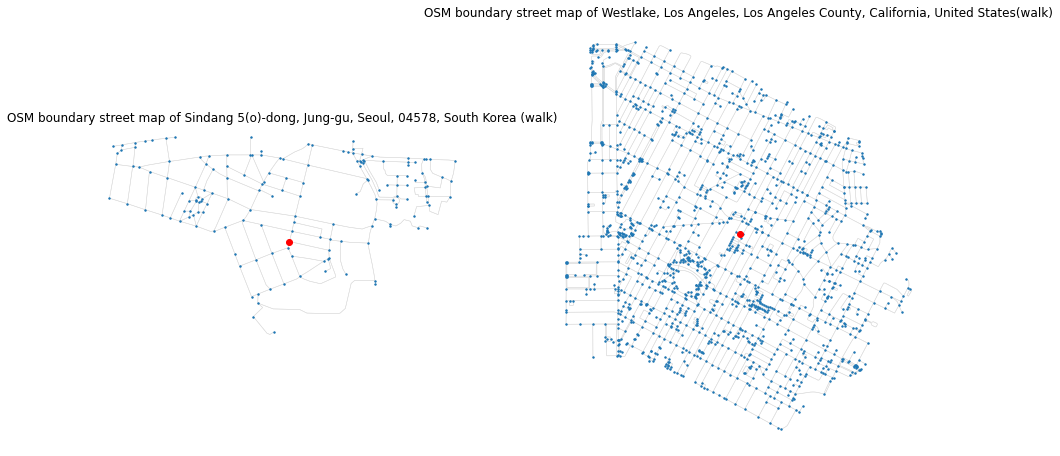

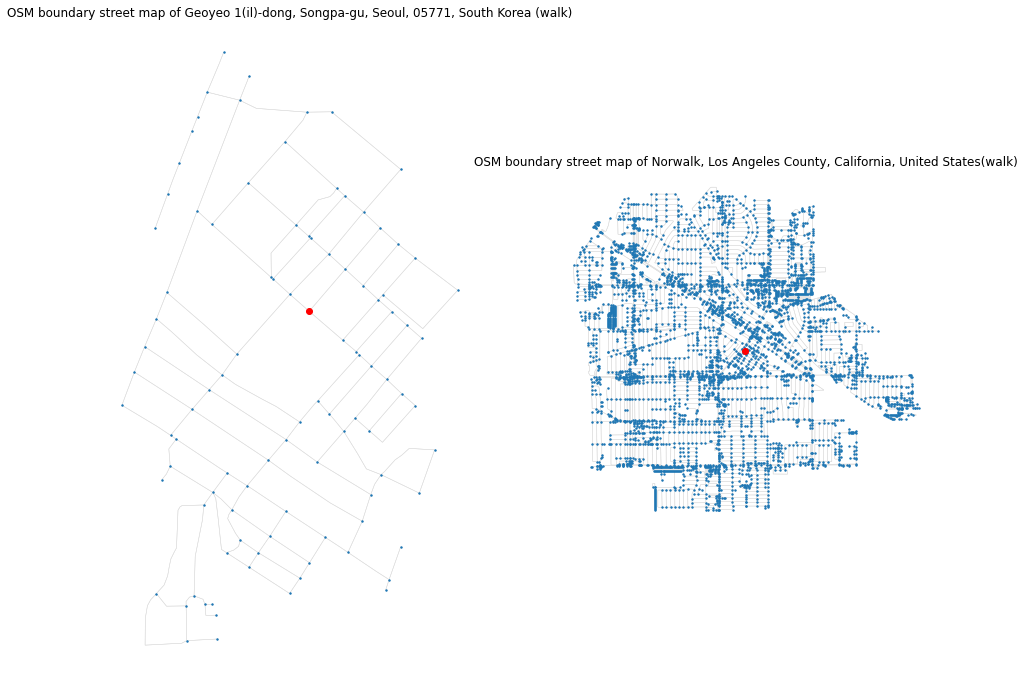

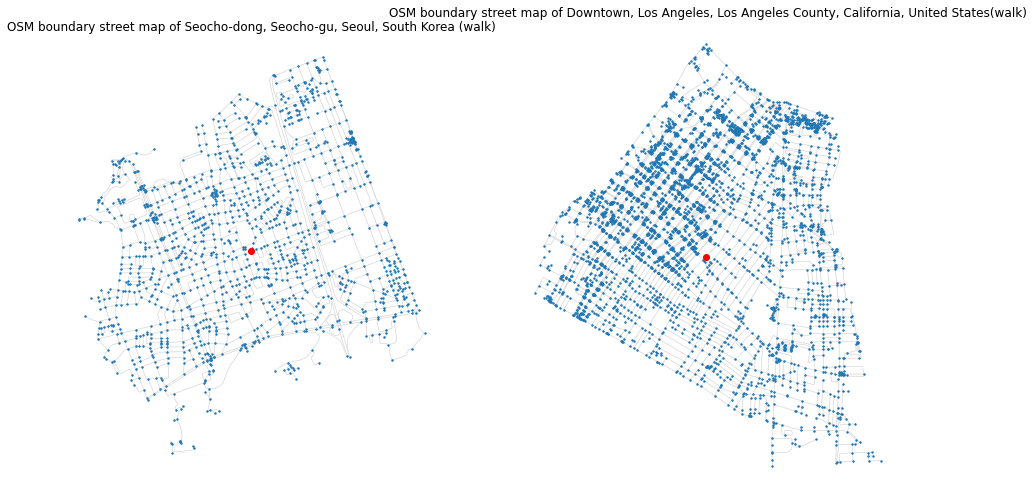

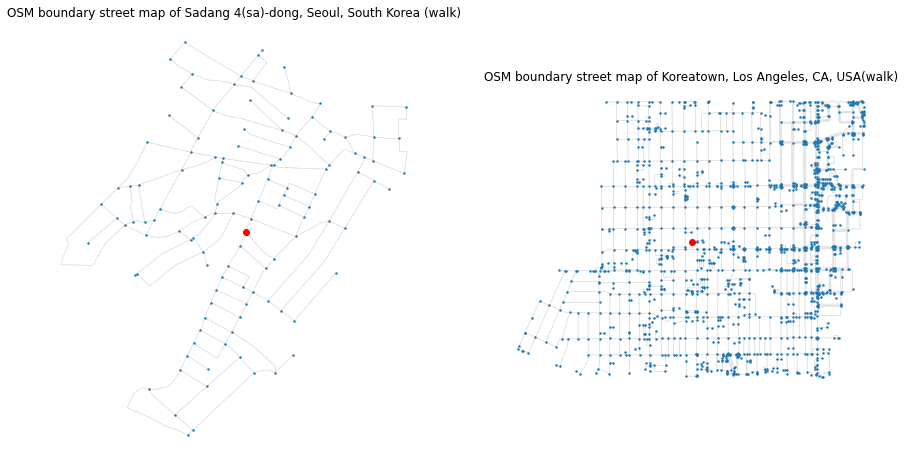

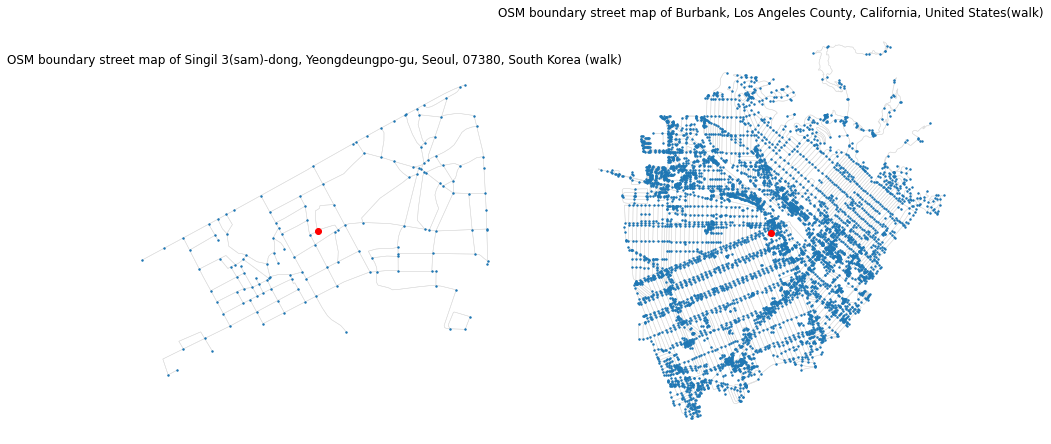

In [6]:
for index, row in place_df_2.iterrows():
    #name = place_df(row['Neighborhood Name']
    neighborhood_area(row['Seoul'], row['Los Angeles'], 'walk')

Areas of the OpenStreetMap-defined neighborhoods are as follows: 

| Criteria                     | Neighborhood       | OSM Surface Area (sq km)|
|------------------------------|--------------------|-------------------------|
| Highest % Commute By Transit | Sindang 5(o)-dong  | 0.52                    |
| Highest % Commute By Transit | Westlake           | 10.4                    |
| Highest % Commute By Car     | Geoyeo 1(il)-dong  | 0.47                    |
| Highest % Commute By Car     | Norwalk            | 41.1                    |
| Highest Rail Ridership       | Seocho-dong        | 10.8                    |
| Highest Rail Ridership       | Downtown           | 23.6                    |
| Highest Population Density   | Sadang 4(sa)-dong  | 0.47                    |
| Highest Population Density   | Koreatown          | 10.8                    |
| Highest Job Density          | Singil 3(sam)-dong | 0.77                    |
| Highest Job Density          | Burbank            | 64.3                    |
 

## Street Grid from_point (central node): Function 

Create function to map the street grid of a neighorhood, given a lat long coordinate point, buffer distance, and the network type.  

osmnx.graph.graph_from_point(center_point, dist=1000, dist_type='bbox', network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
 	
* center_point (tuple) – the (lat, lng) center point around which to construct the graph
* dist (int) – retain only those nodes within this many meters of the center of the graph, with distance determined according to dist_type argument
* dist_type (string {"network", "bbox"}) – if “bbox”, retain only those nodes within a bounding box of the distance parameter. if “network”, retain only those nodes within some network distance from the center-most node.
* network_type (string, {"all_private", "all", "bike", "drive", "drive_service", "walk"}) – what type of street network to get if custom_filter is None
* simplify (bool) – if True, simplify graph topology with the simplify_graph function
* retain_all (bool) – if True, return the entire graph even if it is not connected. otherwise, retain only the largest weakly connected component.
* truncate_by_edge (bool) – if True, retain nodes outside bounding box if at least one of node’s neighbors is within the bounding box
* clean_periphery (bool,) – if True, buffer 500m to get a graph larger than requested, then simplify, then truncate it to requested spatial boundaries
* custom_filter (string) – a custom ways filter to be used instead of the network_type presets e.g., ‘[“power”~”line”]’ or ‘[“highway”~”motorway|trunk”]’. Also pass in a network_type that is in settings.bidirectional_network_types if you want graph to be fully bi-directional.


Source: https://stackoverflow.com/questions/46238813/osmnx-get-coordinates-of-nodes-using-osm-id 

In [7]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

Previously we identified neighborhood pairs for analysis. 

I want to map the street grids of these neighborhoods, ensuring that the street grids cover the same surface area. 

I will find the coordinates for the central node of each neighborhood, and then pass those coordinates to osmnx graph_from_point to map an equidistant radius from that central node.  

Building off from function that downloads the street grid of 2 places and maps the edges with the central node in red, the following function takes two neighborhoods, street grid radius, and walk type as parameters and generates side-by-side street grids centered on the central node of the same size. 

In [8]:
def pair_streetgrid_pt (place1, place2, networktype, distance):    

# NEED TO CALL GRAPH_FROM_PLACE TO FIND CENTER NODE

    # download neighborhood street network
    n1_place = ox.graph_from_place(place1, network_type = networktype)
    n2_place = ox.graph_from_place(place2, network_type = networktype)
    
    # project downloaded network data to Web Mercator (measurements are in meters)
    n1_place_crs = ox.project_graph(n1_place, to_crs='epsg:3857') 
    n2_place_crs = ox.project_graph(n2_place, to_crs='epsg:3857')
    
    # convert nodes and edges to two separate geodataframes 
    n1_node_place, n1_edge_place = ox.graph_to_gdfs(n1_place_crs) 
    n2_node_place, n2_edge_place = ox.graph_to_gdfs(n2_place_crs) 
    
    # get the bounding box coordinates
    n1_minx, n1_miny, n1_maxx, n1_maxy = n1_node_place.geometry.total_bounds
    n2_minx, n2_miny, n2_maxx, n2_maxy = n2_node_place.geometry.total_bounds
    
    # calculate the centroid
    n1_centroid_x = (n1_maxx-n1_minx)/2 + n1_minx
    n1_centroid_y = (n1_maxy-n1_miny)/2 + n1_miny 

    n2_centroid_x = (n2_maxx-n2_minx)/2 + n2_minx
    n2_centroid_y = (n2_maxy-n2_miny)/2 + n2_miny 
    
    # use osmnx's get_nearest_node command to get the id for the nearest node
    n1_center_node = ox.get_nearest_node(n1_place_crs, 
                                  (n1_centroid_y, n1_centroid_x), 
                                  method = 'euclidean') 

    n2_center_node = ox.get_nearest_node(n2_place_crs, 
                                  (n2_centroid_y,n2_centroid_x), 
                                  method = 'euclidean') 
    
    #NEW:
    #define a tuple for the coordinates of each neighborhood's central node 
    n1_lat = n1_place.nodes[n1_center_node]['y']
    n1_long = n1_place.nodes[n1_center_node]['x']
    n1_tuple = (n1_lat, n1_long)
    
    n2_lat = n2_place.nodes[n2_center_node]['y']
    n2_long = n2_place.nodes[n2_center_node]['x']
    n2_tuple = (n2_lat, n2_long)
    
    
# NOW THAT WE FOUND THE CENTER NODE, CALL GRAPH_FROM_POINT 
     # download neighborhood street network
    n1_pt = ox.graph.graph_from_point(n1_tuple, dist = distance, dist_type='bbox', network_type = networktype, simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    n2_pt = ox.graph.graph_from_point(n2_tuple, dist = distance, dist_type='bbox', network_type = networktype, simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    
    # project downloaded network data to Web Mercator (measurements are in meters)
    n1_pt = ox.project_graph(n1_pt, to_crs='epsg:3857') 
    n2_pt = ox.project_graph(n2_pt, to_crs='epsg:3857')
    
    # convert nodes and edges to two separate geodataframes 
    n1_node_pt, n1_edge_pt = ox.graph_to_gdfs(n1_pt) 
    n2_node_pt, n2_edge_pt = ox.graph_to_gdfs(n2_pt) 
    
    
    
    # create the 1x2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 12))
    # name each subplot
    ax1, ax2 = axs
    
# Neighborhood 1 
    n1_edge_pt.plot(ax = ax1,
                            linewidth = 0.5, 
                            edgecolor='gainsboro',
                            zorder=10
                            )  
    # add all nodes to ax
    n1_node_pt.plot(ax=ax1, 
                   markersize=2, 
                   zorder=20)
    
    # add the center node in red also to ax
    n1_node_place.loc[[n1_center_node]].plot(ax = ax1,
                                      color='r', 
                                      zorder=30)
    
    ax1.axis("off")
    ax1.set_title(place1)

# Neighborhood 2 

    # Edge map on the left
    n2_edge_pt.plot(linewidth = 0.5, 
                            edgecolor='gainsboro',
                            zorder=10,
                            ax = ax2)  
    # add all nodes to ax
    n2_node_pt.plot(ax=ax2, 
                   markersize=2, 
                   zorder=20)
    
    # add the center node in red also to ax
    n2_node_place.loc[[n2_center_node]].plot(ax=ax2,
                                      color='r', 
                                      zorder=30)

    ax2.axis("off")
    ax2.set_title(place2)


We used the area covered by 1000 m from the center node. In hindsight, this may have been too large given that for Seoul, the 4 sq km area traverses multiple neighborhoods. If we were to do this analysis again, we probably would set the distance at 500 m to get the 1 sq km area, or perhaps even a smaller scale. 

Walk Street Grids 1000 m from center


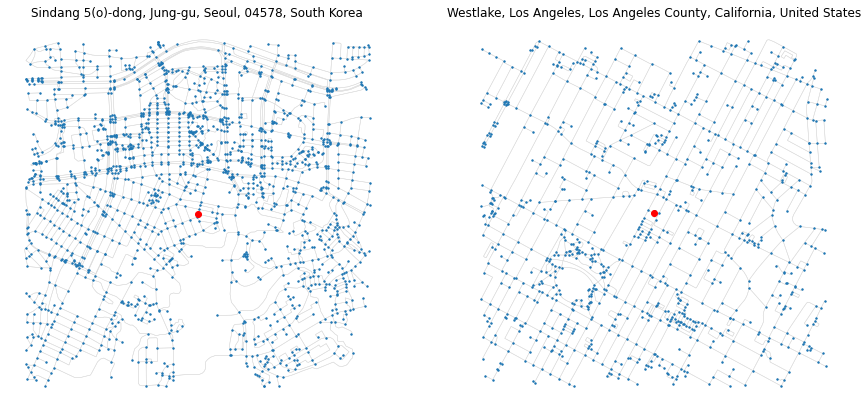

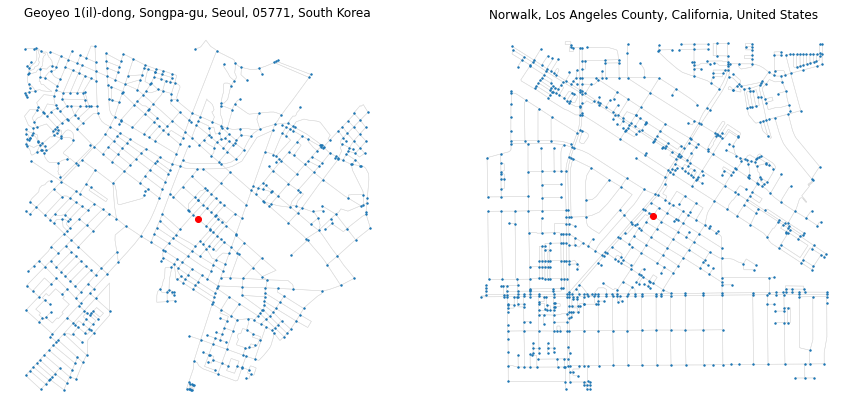

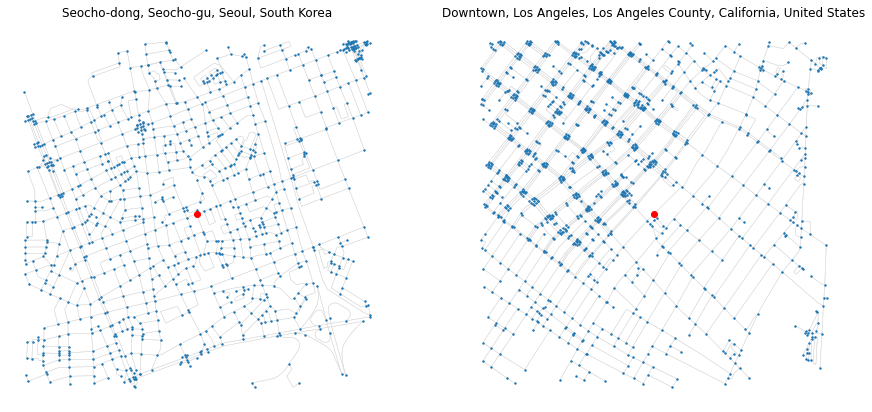

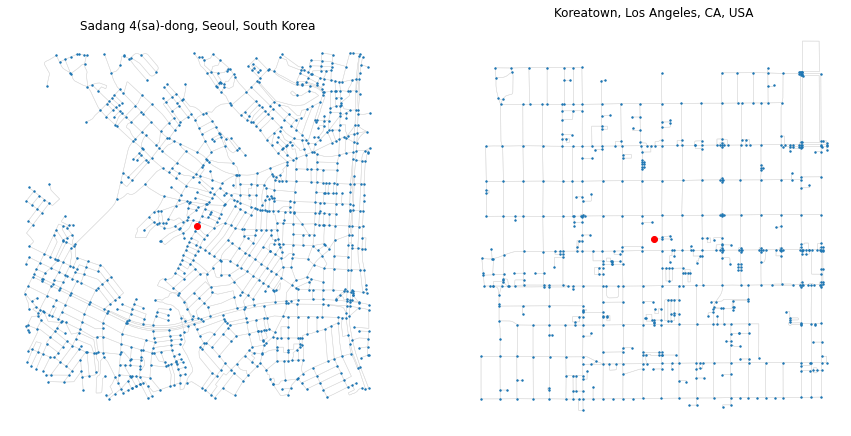

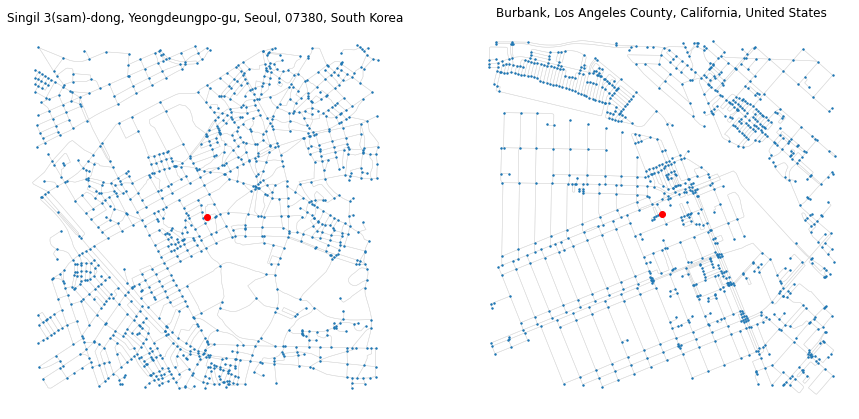

In [9]:
print("Walk Street Grids 1000 m from center")
for index, row in place_df_2.iterrows():
    pair_streetgrid_pt(row['Seoul'], row['Los Angeles'], 'walk', 1000)

## from_place v. from_point  

Now I want to define a function that would take a neighborhood and a distance and a parameter, and map side by side (1) the street grid of the neighborhood at scale defined in Open Street Map, and (2) the street grid 

In [10]:
def place_point (place, networktype, distance):    

# GRAPH_FROM_PLACE 

    # download neighborhood street network
    neighborhood = ox.graph_from_place(place, network_type = networktype) 
    
    # project downloaded network data to Web Mercator (measurements are in meters)
    n_crs = ox.project_graph(neighborhood, to_crs='epsg:3857')  
    
    # convert nodes and edges to two separate geodataframes 
    n_node, n_edge = ox.graph_to_gdfs(n_crs)  
    
    # get the bounding box coordinates
    n_minx, n_miny, n_maxx, n_maxy = n_node.geometry.total_bounds 
    
    # calculate the centroid
    n_centroid_x = (n_maxx-n_minx)/2 + n_minx
    n_centroid_y = (n_maxy-n_miny)/2 + n_miny 
    
    # use osmnx's get_nearest_node command to get the id for the nearest node
    n_center_node = ox.get_nearest_node(n_crs, 
                                  (n_centroid_y, n_centroid_x), 
                                  method = 'euclidean') 
    
    #define a tuple for the coordinates of each neighborhood's central node 
    n_lat = neighborhood.nodes[n_center_node]['y']
    n_long = neighborhood.nodes[n_center_node]['x']
    n_tuple = (n_lat, n_long)
    
    
# GRAPH_FROM_POINT 

     # download neighborhood street network
    neighborhood_pt = ox.graph.graph_from_point(n_tuple, dist = distance, dist_type='bbox', network_type = networktype, simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    
    # project downloaded network data to Web Mercator (measurements are in meters)
    n_pt = ox.project_graph(neighborhood_pt, to_crs='epsg:3857') 
    
    # convert nodes and edges to two separate geodataframes 
    n_node_pt, n_edge_pt = ox.graph_to_gdfs(n_pt) 

    
# MAP BOTH STREET GRIDS 

    # create the 1x2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 12))
    # name each subplot
    ax1, ax2 = axs
    
# Open Street Map Neighborhood Boundaries 
    n_edge.plot(ax = ax1,
                            linewidth = 0.5, 
                            edgecolor='gainsboro',
                            zorder=10
                            )  
    # add all nodes to ax
    n_node.plot(ax=ax1, 
                   markersize=2, 
                   zorder=20)
    
    # add the center node in red also to ax
    n_node.loc[[n_center_node]].plot(ax = ax1,
                                      color='r', 
                                      zorder=30)
    
    ax1.axis("off")
    ax1.set_title(place + " (OSM boundary)")

# Distance from Center Node 

    # Edge map on the left
    n_edge_pt.plot(linewidth = 0.5, 
                            edgecolor='gainsboro',
                            zorder=10,
                            ax = ax2)  
    # add all nodes to ax
    n_node_pt.plot(ax=ax2, 
                   markersize=2, 
                   zorder=20)
    
    # add the center node in red also to ax
    n_node_pt.loc[[n_center_node]].plot(ax=ax2,
                                      color='r', 
                                      zorder=30)

    ax2.axis("off")
    ax2.set_title(place + " (" + str(distance) + " m from center)")


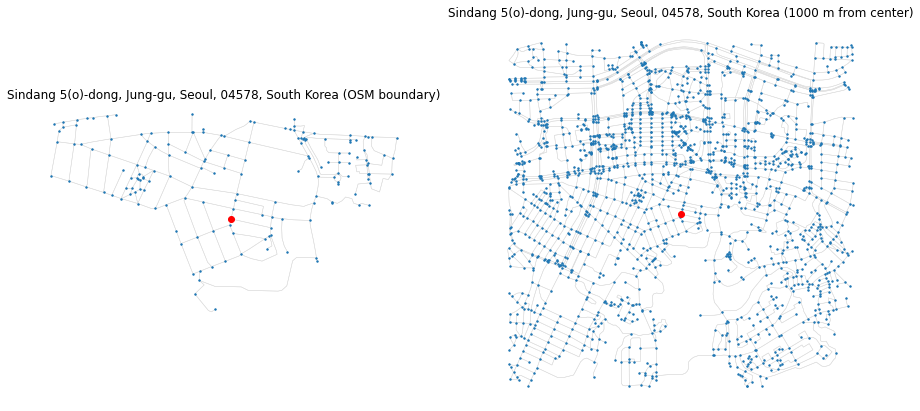

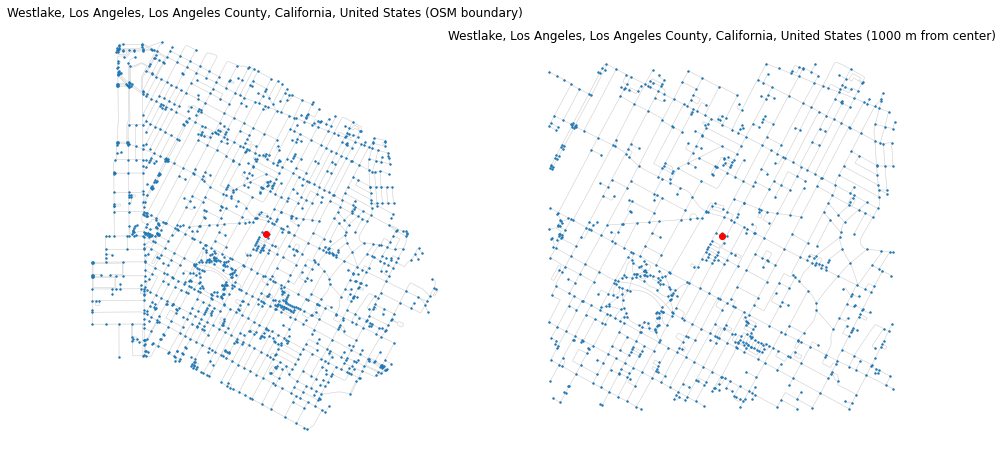

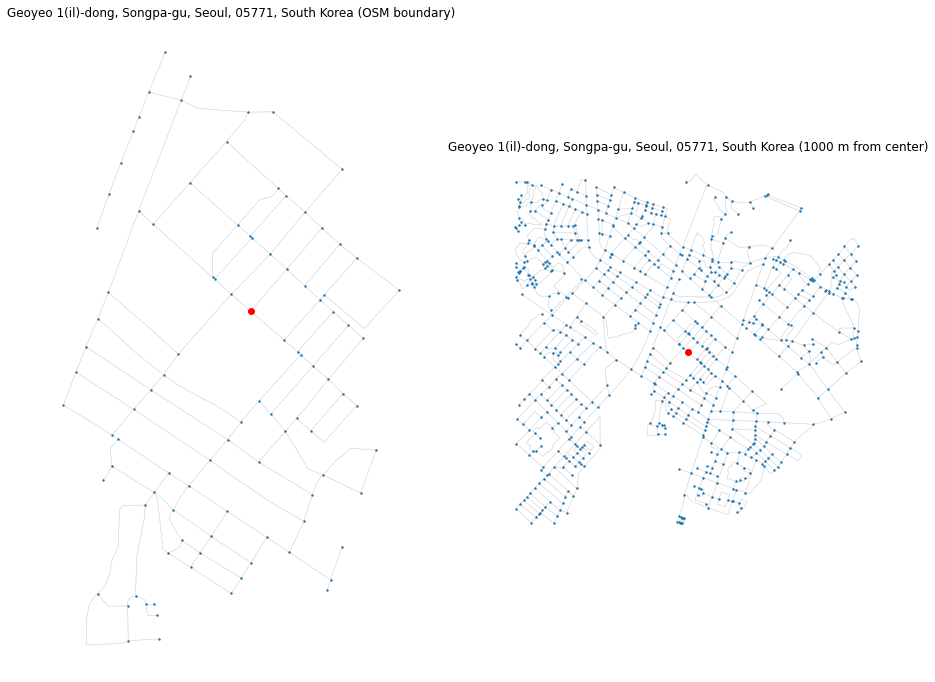

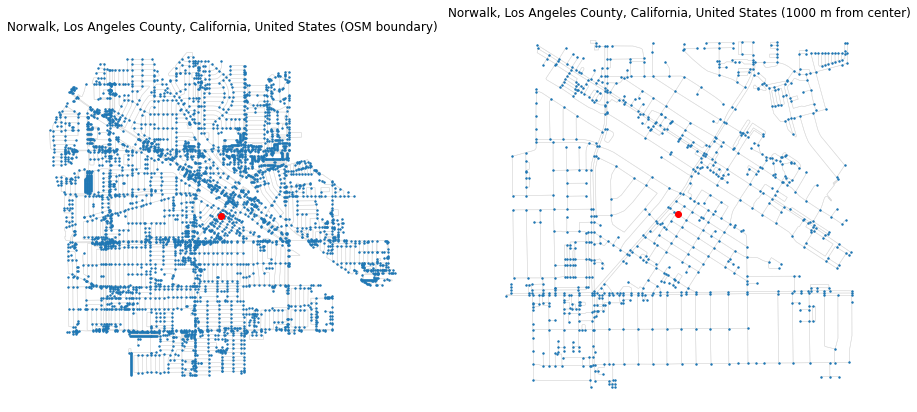

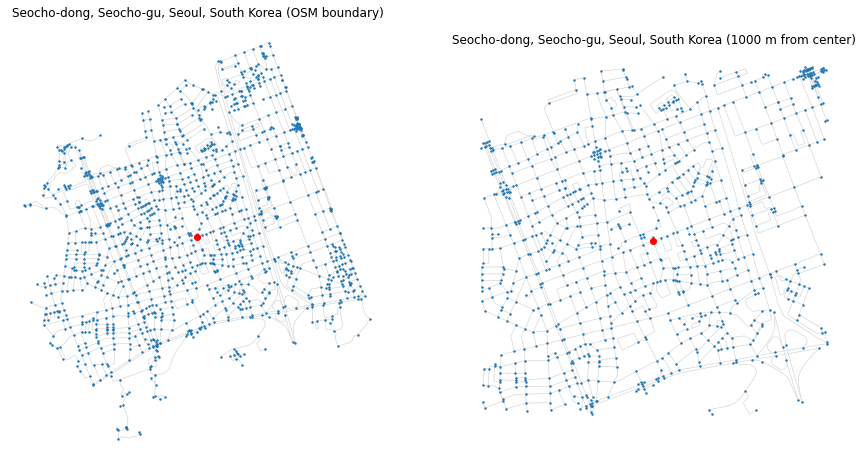

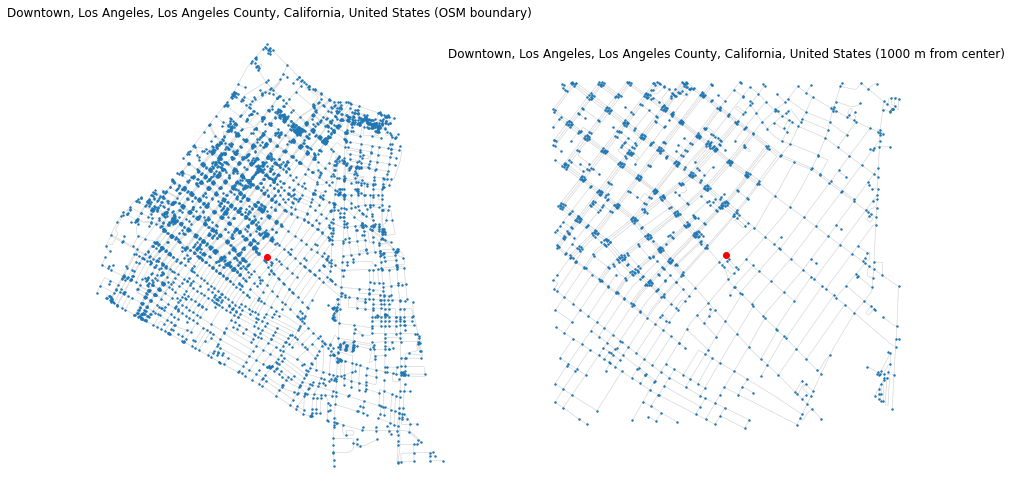

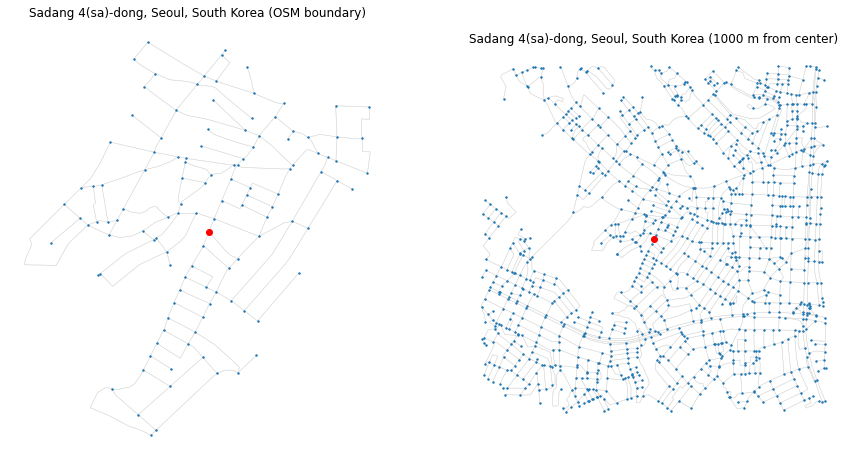

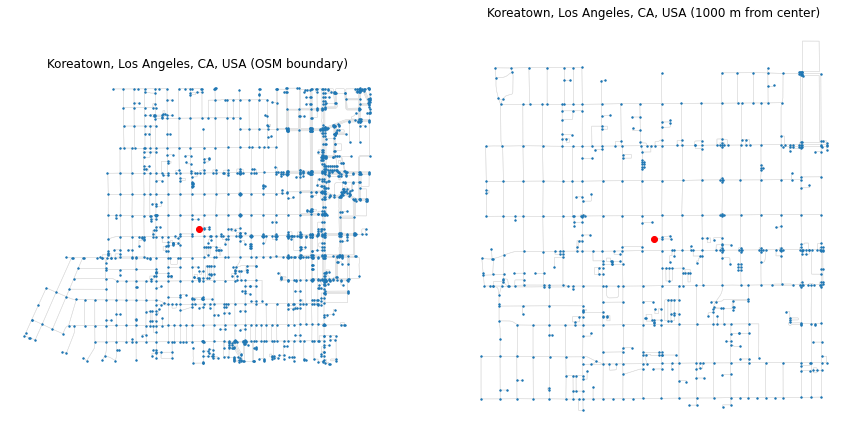

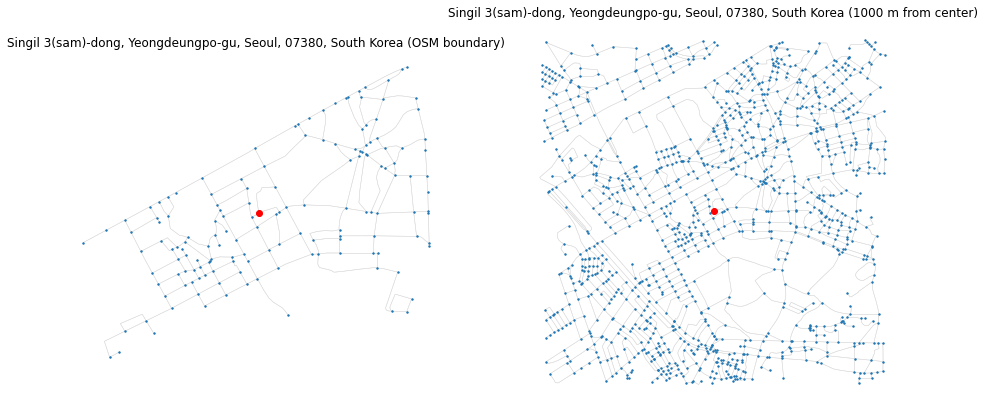

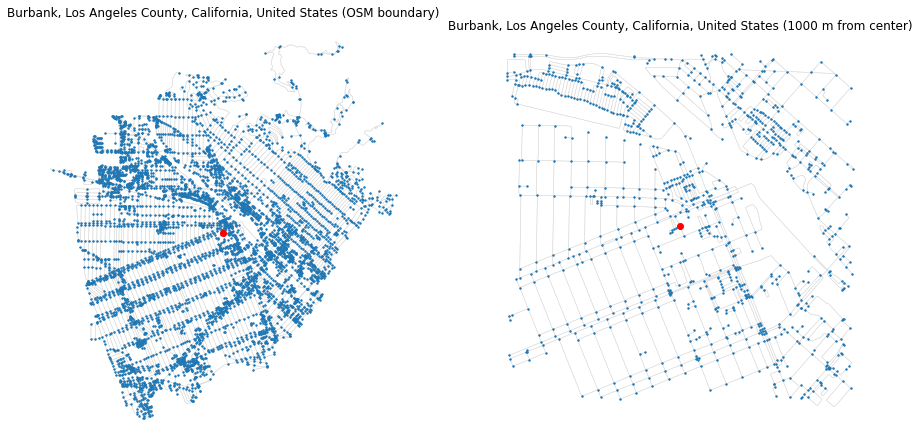

In [11]:
for index, row in place_df.iterrows():
    place_point(row['Neighborhood Name'], 'walk', 1000)